Plan for HP test 1:

  [+] Impl LIF N_Neurons = image size
  [+] Enable feed image to neurons as input
    [+] Try PoissonGroup with non-uniform frequency
  [+] Plot spike rate as image
  [+] Impl HP
  [+] Plot spike rate and thresholds as image after cat
  [ ] Plot statistics on threshold change

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from brian2 import *

/home/alyosha/.conda/envs/py35qt4/lib/python3.5/site-packages/brian2/core/variables.py:174: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return np.issubdtype(np.bool, self.dtype)


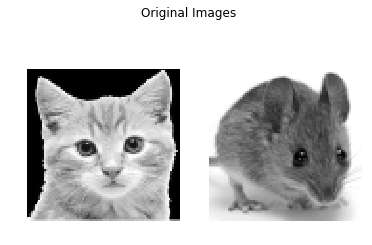

In [3]:
# Load raw images
# img1 = (mpimg.imread('img/cat4.png')[:,:,0] > 0.5).astype(int)
# img2 = (mpimg.imread('img/mouse4.png')[:,:,0] > 0.5).astype(int)
img1 = mpimg.imread('../img/cat4.png')
img2 = mpimg.imread('../img/mouse4.png')

# Plot raw images
fig, axis = plt.subplots(ncols=2)
axis[0].imshow(img1, cmap='gray')
axis[1].imshow(img2, cmap='gray')
axis[0].set_axis_off()
axis[1].set_axis_off()
plt.suptitle('Original Images')
plt.show()

WARNING    /home/alyosha/.conda/envs/py35qt4/lib/python3.5/site-packages/brian2/core/variables.py:174: FutureWarning: Conversion of the second argument of issubdtype from `bool` to `np.generic` is deprecated. In future, it will be treated as `np.bool_ == np.dtype(bool).type`.
  return np.issubdtype(np.bool, self.dtype)
 [py.warnings]
WARNING    Cannot use Cython, a test compilation failed: Cython is not available (ImportError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]


Number of neurons is 6400


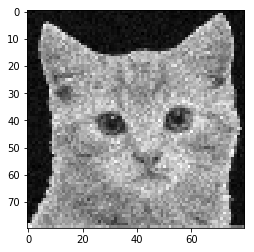

In [4]:
################################################################
# Example 1: Making Poisson neurons spike like a cat
################################################################
start_scope()

N_NEURON = img1.shape[0] * img1.shape[1]
print('Number of neurons is', N_NEURON)

RUN_TIME = 1000*ms
INPUT_BIAS = 10*Hz
INPUT_SENSITIITY = 100*Hz

# Poisson neurons have baseline spike rate, and spike rate caused by input image
P_img1 = PoissonGroup(N_NEURON, INPUT_BIAS + INPUT_SENSITIITY * np.ndarray.flatten(img1))

spikemon = SpikeMonitor(P_img1)

run(RUN_TIME)

# Compute observed spike rate by counting how many times each neuron spiked
rate = np.zeros(N_NEURON)
for i in np.array(spikemon.i):
    rate[i] += float(RUN_TIME)

# Plot observed spike rate 
plt.figure()
plt.imshow(rate.reshape(img1.shape), cmap='gray')
plt.show()

WARNING    /home/alyosha/.conda/envs/py35qt4/lib/python3.5/site-packages/brian2/core/variables.py:174: FutureWarning: Conversion of the second argument of issubdtype from `bool` to `np.generic` is deprecated. In future, it will be treated as `np.bool_ == np.dtype(bool).type`.
  return np.issubdtype(np.bool, self.dtype)
 [py.warnings]
WARNING    "i" is an internal variable of group "synapses", but also exists in the run namespace with the value 6099. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
INFO       No numerical integration method specified for group 'neurongroup', using method 'exact' (took 0.02s). [brian2.stateupdaters.base.method_choice]


Number of neurons is 6400


WARNING    /home/alyosha/.conda/envs/py35qt4/lib/python3.5/site-packages/brian2/core/variables.py:174: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return np.issubdtype(np.bool, self.dtype)
 [py.warnings]


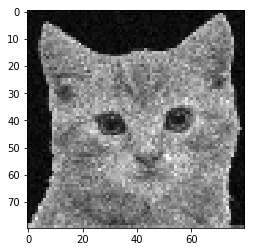

In [5]:
################################################################
# Example 2: Feeding Poisson input into LIF population
################################################################
start_scope()

N_NEURON = img1.shape[0] * img1.shape[1]
print('Number of neurons is', N_NEURON)

RUN_TIME = 1000*ms
INPUT_BIAS = 10*Hz
INPUT_SENSITIITY = 100*Hz
TAU_LEAK = 10*ms
V_THR = 0.8
V0 = 0.0
W0_INPUT = 1.0

# Define LIF neurons that spike for a fixed threshold
eqs = '''
dv/dt = (1-v) / TAU_LEAK : 1
'''

# Connect input Poisson neurons to LIF neurons one-to-one
P_img1 = PoissonGroup(N_NEURON, INPUT_BIAS + INPUT_SENSITIITY * np.ndarray.flatten(img1))
G = NeuronGroup(N_NEURON, eqs, threshold='v > V_THR', reset='v = V0')
S = Synapses(P_img1, G, on_pre='v_post += W0_INPUT')
S.connect(j='i')

# NOTE: As opposed to Example1, here we monitor the spiking of the LIF neurons
spikemon = SpikeMonitor(G)

run(RUN_TIME)

# Compute observed spike rate by counting how many times each neuron spiked
rate = np.zeros(N_NEURON)
for i in np.array(spikemon.i):
    rate[i] += float(RUN_TIME)

# Plot observed spike rate 
plt.figure()
plt.imshow(rate.reshape(img1.shape), cmap='gray')
plt.show()

Some mathematical rules of thumb:
* Typical Firing Threshold, Presynaptic spike rate, presynaptic weight, and leaky timescale are related via $\bar{T} \approx 0.5 \tau_V f_I W_I$
* Typical Firing Threshold increase due to presynaptic spike is roughly $\Delta \bar{T} \approx \bar{T} \frac{\tau_V}{\tau_T}$, where $\tau_T$ is the typical homeostatic plasticity decay rate


WARNING    /home/alyosha/.conda/envs/py35qt4/lib/python3.5/site-packages/brian2/core/variables.py:174: FutureWarning: Conversion of the second argument of issubdtype from `bool` to `np.generic` is deprecated. In future, it will be treated as `np.bool_ == np.dtype(bool).type`.
  return np.issubdtype(np.bool, self.dtype)
 [py.warnings]


Number of neurons is 6400
Threshold growth per spike is 2.5 mV
Typical threshold is 50. mV , voltage increase per spike is 83.33333333 mV
Average threshold after training is 0.03270468522376906


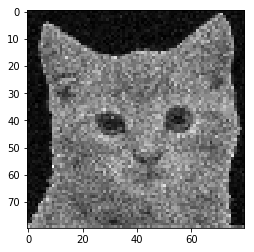

In [16]:
################################################################
# Example 3: Adapting LIF threshold based on its spike rate
################################################################
start_scope()

N_NEURON = img1.shape[0] * img1.shape[1]
print('Number of neurons is', N_NEURON)

RUN_TIME = 2000*ms

LIF_V_TAU = 10*ms
LIF_V_0 = 0.0*mV

LIF_T_TAU = 200*ms
LIF_T_0 = 1.0*mV
LIF_T_AVG = 50.0*mV
LIF_DT_PER_SPIKE = LIF_T_AVG * (LIF_V_TAU / LIF_T_TAU)
print("Threshold growth per spike is", LIF_DT_PER_SPIKE)

# Sync input voltage, so that for average threshold the leak would balance out the input
INPUT_FREQ_0 = 10*Hz
INPUT_FREQ_MAX = 100*Hz
INPUT_FREQ_AVG = INPUT_FREQ_0 + INPUT_FREQ_MAX / 2
INPUT_DV_PER_SPIKE = LIF_T_AVG / LIF_V_TAU / INPUT_FREQ_AVG
print("Typical threshold is", LIF_T_AVG, ", voltage increase per spike is", INPUT_DV_PER_SPIKE)

# Membrane potential V and threshold T both return back to resting values over time
eqs_neu = '''
dv/dt = (LIF_V_0 - v) / LIF_V_TAU : volt
dT/dt = (LIF_T_0 - T) / LIF_T_TAU : volt
'''

# On spike, the threshold is increased
reset = '''
v = LIF_V_0
T += LIF_DT_PER_SPIKE
'''

# Connect Input and LIF one-to-one
P_img1 = PoissonGroup(N_NEURON, INPUT_FREQ_0 + INPUT_FREQ_MAX * np.ndarray.flatten(img1))
G = NeuronGroup(N_NEURON, eqs_neu, threshold='v > T', reset=reset, method='exact')
S = Synapses(P_img1, G, on_pre='v_post += INPUT_DV_PER_SPIKE')
S.connect(j='i')

run(RUN_TIME)

# Plot resulting threshold values
print("Average threshold after training is", np.average(np.array(G.T)))
plt.figure()
plt.imshow(np.array(G.T).reshape(img1.shape), cmap='gray')
plt.show()

In [17]:
################################################################
# Example 4: fixed threshold, sparse lateral connectivity, Symmetric-STDP
################################################################

start_scope()

N_NEURON = img1.shape[0] * img1.shape[1]
print('Number of neurons is', N_NEURON)

RUN_TIME = 2000*ms

# Fixed threshold neurons
LIF_V_TAU = 10*ms
LIF_V_0 = 0.0*mV
LIF_T_0 = 50.0*mV

# Sync input voltage, so that for average threshold the leak would balance out the input
INPUT_FREQ_0 = 10*Hz
INPUT_FREQ_MAX = 100*Hz
INPUT_FREQ_AVG = INPUT_FREQ_0 + INPUT_FREQ_MAX / 2
INPUT_DV_PER_SPIKE = LIF_T_0 / LIF_V_TAU / INPUT_FREQ_AVG
print("Typical threshold is", LIF_T_AVG, ", voltage increase per spike is", INPUT_DV_PER_SPIKE)

# LIF neurons will be sparsely connected laterally
LATERAL_CONN_PROBABILITY = 0.01

# Basic LIF
eqs_neu = '''
dv/dt = (LIF_V_0 - v) / LIF_V_TAU : volt
'''

# On spike, [TODO] weight should be changed according to symmetric-STDP
reset = '''
v = LIF_V_0
'''

# Connect Input and LIF one-to-one
P_img1 = PoissonGroup(N_NEURON, INPUT_FREQ_0 + INPUT_FREQ_MAX * np.ndarray.flatten(img1))
G = NeuronGroup(N_NEURON, eqs_neu, threshold='v > T', reset=reset, method='exact')
S = Synapses(P_img1, G, on_pre='v_post += INPUT_DV_PER_SPIKE')
S.connect(j='i')

S_LAT = Synapses(G, G, on_pre='v_post += INPUT_DV_PER_SPIKE')
S_LAT.connect(p=LATERAL_CONN_PROBABILITY)

run(RUN_TIME)

# Plot resulting threshold values
print("Average threshold after training is", np.average(np.array(G.T)))
plt.figure()
plt.imshow(np.array(G.T).reshape(img1.shape), cmap='gray')
plt.show()

Number of neurons is 6400
Threshold growth per spike is 5. mV
Input weight is 83.33333333 mV


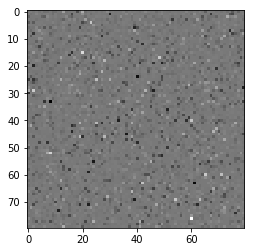

In [22]:
################################################################
# Example 5: Lets have both HP and Lateral Connectivity
################################################################

start_scope()

N_NEURON = img1.shape[0] * img1.shape[1]
print('Number of neurons is', N_NEURON)

RUN_TIME = 1000*ms

LIF_LEAK_TIMESCALE = 10*ms
LIF_POTENTIAL_RESTING = 0.0*mV

LIF_HP_TIMESCALE = 100*ms
LIF_HP_THRESHOLD_RESTING = 1.0*mV
LIF_HP_THRESHOLD_TYPICAL = 50.0*mV
LIF_HP_THRESHOLD_GROWTH = LIF_HP_THRESHOLD_TYPICAL * LIF_LEAK_TIMESCALE / LIF_HP_TIMESCALE
print("Threshold growth per spike is", LIF_HP_THRESHOLD_GROWTH)

INPUT_FREQ_BACKGROUND = 10*Hz
INPUT_FREQ_SENSITIITY = 100*Hz
INPUT_FREQ_TYPICAL = INPUT_FREQ_BACKGROUND + INPUT_FREQ_SENSITIITY / 2
INPUT_WEIGHT = LIF_HP_THRESHOLD_TYPICAL / LIF_LEAK_TIMESCALE / INPUT_FREQ_TYPICAL
print("Input weight is", INPUT_WEIGHT)

LATERAL_CONN_PROBABILITY = 0.01

eqs_neu = '''
dv/dt = (LIF_POTENTIAL_RESTING - v) / LIF_LEAK_TIMESCALE : volt
dT/dt = (LIF_HP_THRESHOLD_RESTING - T) / LIF_HP_TIMESCALE : volt
'''

reset = '''
v = LIF_POTENTIAL_RESTING
T += LIF_HP_THRESHOLD_GROWTH
'''

P_img1 = PoissonGroup(N_NEURON, INPUT_FREQ_BACKGROUND + INPUT_FREQ_SENSITIITY * np.ndarray.flatten(img1))
G = NeuronGroup(N_NEURON, eqs_neu, threshold='v > T', reset=reset)
S_INP = Synapses(P_img1, G, on_pre='v_post += INPUT_WEIGHT')
S_INP.connect(j='i')

S_LAT = Synapses(G, G, on_pre='v_post += INPUT_WEIGHT')
S_LAT.connect(p=LATERAL_CONN_PROBABILITY)

run(RUN_TIME)
    
plt.figure()
plt.imshow(np.array(G.T).reshape(img1.shape), cmap='gray')
plt.show()